##To do
1. predict_log_proba
2. Markdown
3. 排序給予權重，再去計算準確度？ 純看標籤會不會不準？
4. 取前八筆，給予最近的兩(N)筆不同權重(不同的Column來呈現，不要全部放一起)
5. 每一筆自己的Raw rank?
6. 選擇Algorithm (目前留下logreg / KNN / RFC / Bagging)


# 目的

此 Notebook 的目的在於透過顧客的交易紀錄，進而預測此顧客未來的顧客屬性。

我們將顧客屬性分為 ABCDEF 六個等級，未來有新的一筆交易資料進來時，可以透過其歷史購買紀錄和購買種類分布，透過機器學習方式預測其未來最終可能對公司的總貢獻是屬於哪個顧客屬性。

目前擁有的Dataset作為歷史訓練資料集，可以得到他的歷史Rank (god) 以及前N筆購買紀錄當下的Rank變動。

當未來有一筆新的交易紀錄近來，我可以透過此顧客的歷史交易紀錄，來預測此消費者的顧客屬性，並作為後續Promotion / Ecoupon的投遞依據。

In [ ]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
import gc
# %matplotlib inline

In [ ]:
order = pd.read_csv("Orders.csv")

order.drop(index = order[order['StatusDef'] != 'Finish'].index, axis=0, inplace=True)
order.drop(index = order[order['IsGift'] == True].index, axis=0, inplace=True)

order['Mean_Payment'] = order['SalesOrderSlaveTotalPayment'] / order['Quantity']

## 資料處理

首先先處理所有歷史資料，並且給予 god 的標籤，作為預測的目標

首先我們將資料形式做轉變，確保每一個Row僅代表一個商品


In [12]:
order_new = order.drop(columns=order.columns[3:11])
order_new = order_new.drop(columns=order.columns[13:16])
order_new = order_new.drop(columns=order.columns[17:])

repeats = []
for i in range(order_new.shape[0]):
    repeats.append(order_new['Quantity'].values[i])
repeats = np.array(repeats)

order_new = pd.DataFrame(np.repeat(order_new.values, repeats, axis=0), columns=order_new.columns)
order_new['Quantity'] = 1

接著我們將商品種類分群，做為未來商品類別分類的依據

In [15]:
# order_new['UnitPrice'].quantile(.99) == 640  // max == 3500
unit_price_group = pd.cut(order_new['UnitPrice'], bins=[0,160,320,480,640,800,3500]).to_frame()
unit_price_group.columns = ['UnitPriceGroup']
unit_price_group['MemberId'] = order['MemberId']
order_new['UnitPriceGroup'] = unit_price_group['UnitPriceGroup']

In [16]:
order_new = pd.get_dummies(order_new, columns=['UnitPriceGroup'])
order_new.head()

,DateId,MemberId,OrderGroupCode,Quantity,UnitPrice,SalesOrderSlaveTotalPayment,"UnitPriceGroup_(0, 160]","UnitPriceGroup_(160, 320]","UnitPriceGroup_(320, 480]","UnitPriceGroup_(480, 640]","UnitPriceGroup_(640, 800]","UnitPriceGroup_(800, 3500]"
0,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,1,350,350,0,0,1,0,0,0
1,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,1,199,199,0,1,0,0,0,0
2,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,1,199,199,0,1,0,0,0,0
3,20150703,1388133,b'\xd0_\x8eby\xe8\x88\xa5\x85\xe4\x15\nMC\xeaO...,1,225,225,0,1,0,0,0,0
4,20150703,365787,"b""\x04?}pe$m\x7f\x85\xa0y\x81'e5\xca\xbb\xf9\x...",1,100,100,1,0,0,0,0,0


In [17]:
order_df = order_new.groupby(['MemberId'])[['Quantity','UnitPriceGroup_(0, 160]', 'UnitPriceGroup_(160, 320]',
       'UnitPriceGroup_(320, 480]', 'UnitPriceGroup_(480, 640]',
       'UnitPriceGroup_(640, 800]', 'UnitPriceGroup_(800, 3500]']].sum().reset_index()

為了瞭解此顧客的購買次數，我們產生一個新的Dataset叫 Order_count，記錄此MemberId的交易筆數

In [18]:
order_count = order_new.groupby(['MemberId','OrderGroupCode']).count().reset_index()[['MemberId','DateId']]
order_count = order_count.groupby(['MemberId']).count().reset_index()

In [19]:
order_count.columns = ['MemberId','Count']
order_df['Count'] = order_count['Count']
order_count.head()

,MemberId,Count
0,1362,1
1,1384,3
2,1391,4
3,1400,1
4,1423,1


接著我們整理資料，準備生成歷史Rank (god)

In [22]:
order_info = order.drop_duplicates(subset=['MemberId'], keep='first')
order_info.drop(columns=['DateId','OrderGroupCode','Quantity','SalesOrderSlaveId','SalePageId','IsMajor','IsGift','UnitPrice',
                        'PromotionDiscount','ECouponDiscount','SalesOrderSlaveTotalPayment', 'SalesOrderSlaveDateTime',
                       'SalesOrderReceiverId','ZipCode', 'StoreName','StoreId', 'StatusDef', 'ReturnGoodsDateId',
                       'CauseDef','District','IsSalePageGift'], inplace=True)

order_info['MemberId'] = order_info['MemberId'].astype(str).astype(int)
order_df = pd.merge(order_info,order_df,how='left',on=['MemberId'])
order_df.drop(columns=['Mean_Payment'], inplace=True)

In [24]:
p_group = order[['MemberId','Mean_Payment']].groupby('MemberId').mean().reset_index()
order_df = pd.merge(order_df, p_group, on = ['MemberId'], how = 'left')
order_df.head()

取得總交易次數與平均購買金額的分布，進一步產生 bins 進行顧客屬性分類

In [168]:
p_ranking = order.groupby(['MemberId'])[['Mean_Payment']].mean().reset_index()
q_ranking = order.groupby(['MemberId'])[['Quantity']].sum().reset_index()

p_bins = [0, p_ranking['Mean_Payment'].quantile(0.25), p_ranking['Mean_Payment'].quantile(0.5), p_ranking['Mean_Payment'].quantile(0.75), p_ranking['Mean_Payment'].max()]
q_bins = [0, q_ranking['Quantity'].quantile(0.25), q_ranking['Quantity'].quantile(0.5), q_ranking['Quantity'].quantile(0.75), q_ranking['Quantity'].max()]

得到分布後直接進行分類，並且整理與重新排序Dataset

In [29]:
order_df = order_df.assign(A = np.where((order_df['Mean_Payment'] > p_bins[3]) & (order_df['Quantity'] > q_bins[3]), 1,0))
order_df = order_df.assign(B = np.where((order_df['Mean_Payment'] > p_bins[2]) & (order_df['Quantity'] > q_bins[2]) & ((order_df['Quantity'] <= q_bins[3]) | (order_df['Mean_Payment'] <= p_bins[3])), 1,0))
order_df = order_df.assign(C = np.where((order_df['Mean_Payment'] > p_bins[2]) & (order_df['Quantity'] <= q_bins[2]), 1,0))
order_df = order_df.assign(D = np.where((order_df['Mean_Payment'] <= p_bins[2]) & (order_df['Quantity'] > q_bins[2]), 1,0))
order_df = order_df.assign(E = np.where((order_df['Mean_Payment'] <= p_bins[2]) & (order_df['Quantity'] <= q_bins[2]) & ((order_df['Quantity'] > q_bins[1]) |(order_df['Mean_Payment'] > p_bins[1]) ), 1,0))
order_df = order_df.assign(F = np.where((order_df['Mean_Payment'] <= p_bins[1]) & (order_df['Quantity'] <= q_bins[1]), 1,0))

order_df.drop(columns=['Mean_Payment','Quantity'], inplace= True)

In [31]:
rank = pd.Series(order_df['A B C D E F'.split(' ')].columns[np.where(order_df['A B C D E F'.split(' ')]!=0)[1]])
order_df['Rank'] = rank
# Ordering
order_df = order_df[['Rank'] + [c for c in order_df if c not in ['Rank']]]

order_df.drop(labels=['A','B','C','D','E','F'], axis=1, inplace=True)

自己我們得到一個歷史資料的Rank (god)

In [37]:
god = order_df[['MemberId','Rank']]
god.head(10)

,MemberId,Rank
0,1388133,C
1,365787,D
2,1388127,D
3,1230537,A
4,1388164,B
5,1388138,E
6,1370967,D
7,1388120,D
8,505220,E
9,1388211,F


In [38]:
del order_info, order_new, order_df
del p_ranking, q_ranking, p_bins, q_bins
del rank

import gc
gc.collect()

28

我們已經取得歷史資料的Rank，作為後續機學習的預測目標。接下來我們必須整理資料，找出頭N筆的交易紀錄，並且根據這個紀錄給予當下的Rank。

倘若我們能知道前T筆的交易紀錄即可預測出他未來的顧客屬性，那我們就可以及時給予適當的Promotion 和 Ecoupon 讓客戶購買更多商品 / 購買更多次數

------------------------------------------------------------

下方我們依序整理出頭一筆 至 頭十筆的交易紀錄，以及當下的Rank

In [39]:
# 取出每個MemberId第一筆購買紀錄
member_1st_purchase_date = order.sort_values(by='DateId').groupby('MemberId')[['DateId','OrderGroupCode']].nth(0).reset_index() 

# Join兩個Dataset，留下第一筆購買紀錄
merge = pd.merge(order, member_1st_purchase_date, on = ['MemberId','DateId','OrderGroupCode'], how = 'right')
merge_1st = merge.copy()

In [40]:
def clean_data(dataset):
    # Drop unneeded columns
    dataset.drop(columns=['IsGift','IsMajor','StatusDef','OrderGroupCode','IsSalePageGift','ZipCode','StoreName','StoreId','ReturnGoodsDateId','CauseDef','District','SalesOrderSlaveDateTime','SalesOrderReceiverId','SalePageId'], axis=1, inplace=True)
    upbound = order['UnitPrice'].quantile(.99)
    maxi = order['UnitPrice'].max()
    unit_price_group = pd.cut(dataset['UnitPrice'], bins=[0,upbound/4,upbound/2,3*upbound/4,upbound,maxi]).to_frame() # max = 2600
    
    unit_price_group.columns = ['UnitPriceGroup']
    unit_price_group['MemberId'] = dataset['MemberId']
    dataset['UnitPriceGroup'] = unit_price_group['UnitPriceGroup']

    df_cut = dataset.drop_duplicates(subset = ['MemberId'], keep = 'first').reset_index()
    df_cut.drop(columns = ['DateId','index','SalesOrderSlaveId','Quantity', 'UnitPrice','PromotionDiscount','ECouponDiscount'], inplace=True)

    repeats = []
    for i in range(dataset.shape[0]):
        repeats.append(dataset['Quantity'].values[i])
    repeats = np.array(repeats)

    dataset = pd.DataFrame(np.repeat(dataset.values, repeats, axis=0), columns=dataset.columns)
    dataset = pd.get_dummies(dataset, columns = ['UnitPriceGroup'])
    dataset['Quantity'] = 1

    df_cut_group = dataset.groupby('MemberId').sum().reset_index()
    df_cut_group['MemberId'] = df_cut_group['MemberId'].astype(int)
    df_cut['MemberId'] = df_cut['MemberId'].astype(int)
    df_cut = pd.merge(df_cut, df_cut_group, on = 'MemberId', how = 'left')

    # ECoupon
    df_cut['ECoupon'] = (df_cut['ECouponId'] != 0)
    df_cut = df_cut.assign(ECoupon = np.where(df_cut['ECouponId'] !=0 , 1, 0))

    # City Area
    north = ['新北市','台北市','桃園市','新竹市','新竹市','苗栗縣','基隆市']
    mid = ['台中市','彰化縣','雲林縣','南投縣']
    south = ['高雄市','台南市','屏東縣','嘉義縣','嘉義市','屏東市']
    east = ['宜蘭縣','花蓮縣','台東縣','台東市']
    island = ['澎湖縣']
    df_cut = df_cut.assign(North = np.where(df_cut['City'].isin(north), 1, 0))
    df_cut = df_cut.assign(Mid = np.where(df_cut['City'].isin(mid), 1, 0))
    df_cut = df_cut.assign(South = np.where(df_cut['City'].isin(south), 1, 0))
    df_cut = df_cut.assign(East = np.where(df_cut['City'].isin(east), 1, 0))

    df_cut.drop(columns=['ECouponId','City','UnitPriceGroup','Mean_Payment','SalesOrderSlaveTotalPayment'], inplace = True)
    df_cut = pd.get_dummies(df_cut, columns=['TrackSourceTypeDef','TrackDeviceTypeDef','PayProfileTypeDef','DeliverTypeDef'], drop_first=True)
    
    p_group = order[(order['IsMajor'] == True) & (order['StatusDef'] == 'Finish')][['MemberId','Mean_Payment']].groupby('MemberId').mean().reset_index()
    s_group = order[(order['IsMajor'] == True) & (order['StatusDef'] == 'Finish')][['MemberId','SalesOrderSlaveTotalPayment']].groupby('MemberId').sum().reset_index()
    df_cut = pd.merge(df_cut, p_group, on = ['MemberId'], how = 'left')
    df_cut = pd.merge(df_cut, s_group, on = ['MemberId'], how = 'left')
    
    df_cut = pd.merge(df_cut, god, on = 'MemberId', how='left')
    df_cut = df_cut[['Rank','MemberId','Mean_Payment','Quantity','SalesOrderSlaveTotalPayment'] + 
                    [c for c in df_cut if c not in ['Rank','MemberId','Mean_Payment','Quantity','SalesOrderSlaveTotalPayment']]]

    del df_cut_group
    del unit_price_group
    del repeats
    del north, mid, south, east, island
    del p_group, s_group
    
    import gc
    gc.collect()
    
    return(df_cut)

In [41]:
def get_rank(dataset):
    d = dataset[['MemberId','Mean_Payment','Quantity']]
    
    p_ranking = d.groupby(['MemberId'])[['Mean_Payment']].mean().reset_index()
    q_ranking = d.groupby(['MemberId'])[['Quantity']].sum().reset_index()

    p_bins = [0, p_ranking['Mean_Payment'].quantile(0.25), p_ranking['Mean_Payment'].quantile(0.5), p_ranking['Mean_Payment'].quantile(0.75), p_ranking['Mean_Payment'].max()]
    q_bins = [0, q_ranking['Quantity'].quantile(0.25), q_ranking['Quantity'].quantile(0.5), q_ranking['Quantity'].quantile(0.75), q_ranking['Quantity'].max()]

    d = d.assign(A = np.where((d['Mean_Payment'] > p_bins[3]) & (d['Quantity'] > q_bins[3]), 1,0))
    d = d.assign(B = np.where((d['Mean_Payment'] > p_bins[2]) & (d['Quantity'] > q_bins[2]) & ((d['Quantity'] <= q_bins[3]) | (d['Mean_Payment'] <= p_bins[3])), 1,0))
    d = d.assign(C = np.where((d['Mean_Payment'] > p_bins[2]) & (d['Quantity'] <= q_bins[2]), 1,0))
    d = d.assign(D = np.where((d['Mean_Payment'] <= p_bins[2]) & (d['Quantity'] > q_bins[2]), 1,0))
    d = d.assign(E = np.where((d['Mean_Payment'] <= p_bins[2]) & (d['Quantity'] <= q_bins[2]) & ((d['Quantity'] > q_bins[1]) |(d['Mean_Payment'] > p_bins[1]) ), 1,0))
    d = d.assign(F = np.where((d['Mean_Payment'] <= p_bins[1]) & (d['Quantity'] <= q_bins[1]), 1,0))

    rank = pd.Series(d['A B C D E F'.split(' ')].columns[np.where(d['A B C D E F'.split(' ')]!=0)[1]])
    d['Rank'] = rank
    # Ordering
    d = d[['Rank'] + [c for c in d if c not in ['Rank']]]

    ranking = d[['MemberId','Rank']]
    
    return(ranking)

In [42]:
df_1st = clean_data(merge_1st)
df_1st.head()

,Rank,MemberId,Mean_Payment,Quantity,SalesOrderSlaveTotalPayment,"UnitPriceGroup_(0.0, 160.0]","UnitPriceGroup_(160.0, 320.0]","UnitPriceGroup_(320.0, 480.0]","UnitPriceGroup_(480.0, 640.0]","UnitPriceGroup_(640.0, 3500.0]",...,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven
0,C,1388133,243.250000,4,973.0,0,3,1,0,0,...,1,0,0,0,0,0,0,1,0,1
1,D,1388127,180.625000,5,1445.0,1,4,0,0,0,...,1,0,0,0,0,1,0,0,0,0
2,A,1230537,306.245614,10,17456.0,0,8,1,1,0,...,0,0,0,0,1,0,0,0,1,0
3,B,1388164,235.833333,5,1415.0,0,4,1,0,0,...,1,0,1,0,0,1,0,0,0,0
4,E,1388138,159.400000,5,797.0,0,5,0,0,0,...,1,0,1,0,0,0,0,1,0,1


In [43]:
df_1st_rank = get_rank(df_1st)
df_1st_rank.columns = ['MemberId','1st_rank']
df_1st_raw_rank = df_1st_rank

In [44]:
del member_1st_purchase_date

gc.collect()

91

-------------------------------------------

處理看看頭兩筆資料

In [66]:
def get_nth_record(n):
    id_list_nonvalid = list(order_count[order_count['Count'] <= (n-1)]['MemberId'])
    id_list_valid = list(order_count[order_count['Count'] >= n]['MemberId'])
    valid_order = order[order['MemberId'].isin(id_list_valid)].sort_values(by='DateId').reset_index()
    
    purchase_date = valid_order.drop_duplicates(subset=['MemberId','OrderGroupCode'], keep='first').groupby('MemberId')[['OrderGroupCode','DateId']].nth((n-1)).reset_index()
    raw = pd.merge(valid_order, purchase_date, on = ['MemberId','DateId','OrderGroupCode'], how = 'right')
    results = merge[~merge['MemberId'].isin(id_list_nonvalid)].append(raw).drop(columns=['index'])
    
    del id_list_nonvalid, id_list_valid
    del valid_order, purchase_date, raw
    
    gc.collect()
    
    return(results)

In [65]:
merge_2nd = get_nth_record(2)
df_2nd = clean_data(merge_2nd)
df_2nd_rank = get_rank(df_2nd)
df_2nd_rank.columns = ['MemberId','2nd_rank']
df_2nd_rank.head()

,MemberId,2nd_rank
0,1388127,D
1,1230537,A
2,1388164,C
3,1370967,D
4,1374116,D


--------------------------------------

In [68]:
merge_3rd = get_nth_record(3)
df_3rd = clean_data(merge_3rd)
df_3rd_rank = get_rank(df_3rd)
df_3rd_rank.columns = ['MemberId','3nd_rank']
df_3rd_rank.head()

,MemberId,3nd_rank
0,1230537,A
1,1370967,D
2,1374116,D
3,1243605,C
4,1375914,D


In [70]:
merge_4th = get_nth_record(4)
df_4th = clean_data(merge_4th)
df_4th_rank = get_rank(df_4th)
df_4th_rank.columns = ['MemberId','4th_rank']
df_4th_rank.head()

,MemberId,4th_rank
0,1230537,A
1,1370967,E
2,1374116,E
3,1243605,C
4,1375914,E


In [72]:
merge_5th = get_nth_record(5)
df_5th = clean_data(merge_5th)
df_5th_rank = get_rank(df_5th)
df_5th_rank.columns = ['MemberId','5th_rank']
df_5th_rank.head()

,MemberId,5th_rank
0,1230537,A
1,1370967,E
2,1374116,D
3,1243605,C
4,1375914,D


In [74]:
merge_6th = get_nth_record(6)
df_6th = clean_data(merge_6th)
df_6th_rank = get_rank(df_6th)
df_6th_rank.columns = ['MemberId','6th_rank']
df_6th_rank.head()

,MemberId,6th_rank
0,1370967,E
1,1374116,E
2,1375914,E
3,619660,C
4,823620,E


In [76]:
merge_7th = get_nth_record(7)
df_7th = clean_data(merge_7th)
df_7th_rank = get_rank(df_7th)
df_7th_rank.columns = ['MemberId','7th_rank']
df_7th_rank.head()

,MemberId,7th_rank
0,1374116,D
1,619660,C
2,1207723,E
3,525570,E
4,919268,B


In [78]:
merge_8th = get_nth_record(8)
df_8th = clean_data(merge_8th)
df_8th_rank = get_rank(df_8th)
df_8th_rank.columns = ['MemberId','8th_rank']
df_8th_rank.head()

,MemberId,8th_rank
0,1374116,F
1,619660,B
2,1207723,E
3,525570,E
4,919268,B


In [319]:
#### df_8th_rank.head()

,MemberId,8th_rank
0,1374116,F
1,619660,B
2,1207723,E
3,525570,E
4,919268,B


In [327]:
#### df_8th[['MemberId','Rank']].head()

,MemberId,Rank
0,1374116,D
1,619660,A
2,1207723,D
3,525570,D
4,919268,B


In [79]:
merge_9th = get_nth_record(9)
df_9th = clean_data(merge_9th)
df_9th_rank = get_rank(df_9th)
df_9th_rank.columns = ['MemberId','9th_rank']
df_9th_rank.head()

,MemberId,9th_rank
0,1374116,D
1,619660,C
2,1207723,E
3,919268,B
4,1171712,B


In [80]:
merge_10th = get_nth_record(10)
df_10th = clean_data(merge_10th)
df_10th_rank = get_rank(df_10th)
df_10th_rank.columns = ['MemberId','10th_rank']
df_10th_rank.head()

,MemberId,10th_rank
0,1374116,D
1,1207723,F
2,1171712,B
3,1443639,C
4,436800,E


In [152]:
del merge_1st, merge_2nd, merge_3rd, merge_4th, merge_5th
del merge_6th, merge_7th, merge_8th, merge_9th, merge_10th
gc.collect()

35

得到頭十筆交易的Rank後，我們將其列出與Rank做比較

In [82]:
df_all = god
df_all.columns = ['MemberId','God']
rank_list = [df_1st_rank, df_2nd_rank, df_3rd_rank, df_4th_rank, df_5th_rank, df_6th_rank,
            df_7th_rank, df_8th_rank, df_9th_rank, df_10th_rank]
for i in rank_list:
    df_all = pd.merge(df_all, i, how = 'left', on = ['MemberId'])

從下面的表我們可以發現每一次交易進來，顧客的屬性都可能會有所波動

In [90]:
df_all[df_all['10th_rank'].isin('A B C D E F'.split(' '))]

,MemberId,God,1st_rank,2nd_rank,3nd_rank,4th_rank,5th_rank,6th_rank,7th_rank,8th_rank,9th_rank,10th_rank
12,1374116,D,D,D,D,E,D,E,D,F,D,D
33,1207723,D,D,D,E,D,E,F,E,E,E,F
101,1171712,B,B,B,B,B,B,B,C,B,B,B
109,1443639,B,C,C,C,C,C,C,C,C,C,C
123,436800,B,C,C,C,C,C,C,C,E,E,E
135,1225562,D,D,E,E,E,F,D,F,F,E,F
136,1276894,D,D,D,E,E,E,E,E,D,E,D
144,932241,D,E,E,E,E,E,F,F,F,F,E
146,1281330,D,F,F,F,F,F,F,F,F,F,F
181,417910,A,C,C,C,C,C,C,C,C,C,C


從這些歷史資料來看，預測的準確度高不高呢？ 我們來看看他跟God的相似度有多少

In [92]:
temp = df_all[df_all['10th_rank'].isin('A B C D E F'.split(' '))]
sc = []
for i in range(10):
    temp['temp'] = (temp['God'] == temp.iloc[:,i+2])
    score = round(temp['temp'].sum() / temp.shape[0],2)
    sc.append(score)
sc

,MemberId,God,1st_rank,2nd_rank,3nd_rank,4th_rank,5th_rank,6th_rank,7th_rank,8th_rank,9th_rank,10th_rank,temp
12,1374116,D,D,D,D,E,D,E,D,F,D,D,True
33,1207723,D,D,D,E,D,E,F,E,E,E,F,False
101,1171712,B,B,B,B,B,B,B,C,B,B,B,True
109,1443639,B,C,C,C,C,C,C,C,C,C,C,False
123,436800,B,C,C,C,C,C,C,C,E,E,E,False


我們希望透過機器學習方法去預測，下方我們將進行實際操作。

-------------------------------

--------------------

# Pre-Modeling Task

In [330]:
# We are dealing with a classification problem.
# Therefore, let's import some classification algorithms.
from sklearn.model_selection import cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=3)  # Make sure the predict_proba prints out three digits

In [139]:
cv = 3
# cv = ShuffleSplit(n_splits = 10, test_size=.3, train_size=.6)

### Logistic Regression

In [100]:
from datetime import datetime

In [269]:
df_list = [df_1st, df_2nd, df_3rd, df_4th, df_5th, df_6th, df_7th, df_8th, df_9th, df_10th]

In [341]:
def fit_classification_model_with_rfe(model, dataset):
    print("Dataset start modeling.")
    print(datetime.now())
    # Create validating dataset
    val = dataset.iloc[:round(dataset.shape[0]/4),:]
    dat = dataset.iloc[round(dataset.shape[0]/4):,:]

    ans = val['Rank']

    # Seperate training dataset
    X = dat.drop(['Rank'], axis = 1)
    y = dat['Rank']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    X_test_id = list(X_test['MemberId'])
    
    for k in [X_train, X_test, y_train, y_test]:
        k.drop(columns = 'MemberId', axis = 1, inplace = True)
    
    #### Accy
    
    mod = model()
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
    mod_accy = accuracy_score(y_pred, y_test)
    print("Model Accy get.")
    print(datetime.now())
    
    #### Prob
    
    prob = pd.DataFrame(mod.predict_proba(X_test))
    if prob.shape[1] == 6:
        prob.columns = ['A','B','C','D','E','F']
    elif prob.shape[1] == 5:
        prob.columns = ['A','B','C','D','E']
    else:
        prob.columns = ['A','B','D']
    
    t = []
    for i in range(prob.shape[0]):
        emp = list(prob.iloc[i].sort_values(ascending = False).index)
        t.append(emp)
    prob['Probability'] = t
    prob['MemberId'] = X_test_id
    prob = pd.merge(prob, god, how='left', on='MemberId')
    
    # Ordering
    prob = prob[['MemberId', 'God'] + [c for c in prob if c not in ['MemberId','God']]]
    print("Model Probability get.")
    print(datetime.now())
    
    #### RFE
    # RFE
    rfe = RFE(estimator=mod, n_features_to_select=1, step=1, verbose=2)
    rfe.fit(X_train, y_train)
    rfe_rank = rfe.ranking_
    print("Model RFE get.")
    print("Modeling Ends.")
    print(datetime.now())
    print('----------------------------------')
    return(mod_accy, prob, rfe_rank)

In [342]:
logreg_accy = []
prob_list = []
rfe_list = []
for i in df_list:
    accy , prob , rfe = fit_classification_model_with_rfe(LogisticRegression, i)
    logreg_accy.append(accy)
    prob_list.append(prob)
    rfe_list.append(rfe)

Dataset start modeling.
2019-06-06 12:10:50.361225
Model Accy get.
2019-06-06 12:11:15.467100
Model Probability get.
2019-06-06 12:12:03.461781
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Model RFE get.
2019-06-06 12:16:06.529910
Dataset start modeling.
2019-0

Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Model RFE get.
2019-06-06 12:20:21.622887
Dataset start modeling.
2019-06-06 12:20:21.622887
Model Accy get.
2019-06-06 12:20:22.667098
Model Probability get.
2019-06-06 12:20:23.459976
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 feature

In [343]:
logreg_accy

[0.7759355447359004,
 0.815692138191548,
 0.8241056633200117,
 0.8255561802264878,
 0.874721465709334,
 0.8977583378895572,
 0.7958128715430344,
 0.8826040554962646,
 0.7463837994214079,
 0.7333755541481951]

In [346]:
pd.DataFrame(rfe_list)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,21,3,22,2,4,11,6,1,7,20,...,15,14,18,23,12,9,5,13,8.0,10.0
1,20,1,21,2,3,7,5,4,6,18,...,13,14,19,22,12,8,23,11,10.0,9.0
2,19,4,20,6,7,1,2,3,5,16,...,17,18,21,22,11,9,12,10,8.0,NaN
3,20,1,22,6,7,4,3,2,5,15,...,18,17,21,8,11,10,13,12,9.0,NaN
4,20,1,21,6,7,4,3,2,5,14,...,15,16,11,22,19,10,12,13,9.0,NaN
5,12,21,22,18,20,17,2,1,13,11,...,14,15,19,16,6,5,7,3,4.0,NaN
6,15,21,22,17,20,18,2,1,3,14,...,4,5,19,16,9,7,11,6,8.0,NaN
7,14,21,22,17,19,18,16,1,2,13,...,3,4,20,15,11,6,12,5,7.0,NaN
8,16,21,22,17,20,18,3,1,2,15,...,5,4,6,19,10,7,11,8,9.0,NaN
9,13,20,21,18,16,14,3,1,2,12,...,7,19,17,15,6,10,4,5,NaN,NaN


後續會根據Probability的排序，生產出另外一組含權重的Accuracy，而非僅看標籤相不相同，而是看預測是否接近 (未完)

同理，下方的演算法也會用同樣方法進行操作，目前尚未完成

### KNN

In [176]:
knn_scores = []
best_pred = [-1,-1]
print(datetime.now())
for i in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = i, weights='distance', metric = 'minkowski', p=2)
    knn.fit(X_train, y_train)
    score = accuracy_score(y_test, knn.predict(X_test))
    
    if score > best_pred[1]:
        best_pred = [i, score]
    knn_scores.append(score)
print(datetime.now())

2019-05-28 00:20:19.222171
2019-05-28 00:21:17.901576


[14, 0.35277979592058034]


Text(0.5, 1.0, 'Score vs. i')

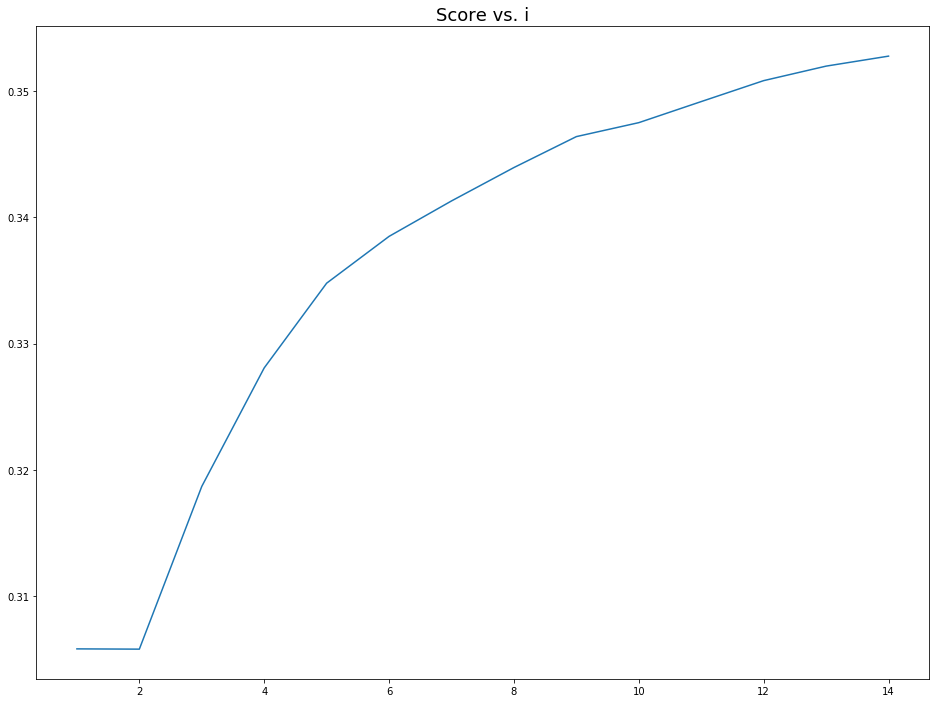

In [177]:
print(best_pred)
plt.figure(figsize=(16,12))
plt.plot(range(1,15),knn_scores)
plt.title('Score vs. i', fontsize = 18)

In [178]:
# 有Predict_proba

print(datetime.now())
knn = KNeighborsClassifier(n_neighbors=14, weights='distance', metric = 'minkowski', p=2, n_jobs=-1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_accy = accuracy_score(y_test, y_pred)
print(datetime.now())

2019-05-28 00:22:26.586089
2019-05-28 00:22:30.385932


In [179]:
knn_accy

0.35277979592058034

### Bagging Classifier

In [161]:
# 有Predict_proba

print(datetime.now())
bag = BaggingClassifier()
bag.fit(X_train,y_train)
y_pred = bag.predict(X_test)
bag_accy = accuracy_score(y_test, y_pred)
bag_accy
print(datetime.now())

2019-05-25 10:08:36.375753
2019-05-25 10:08:44.453183


### Random Forest Classifier

In [101]:
print(datetime.now())
rfc = RandomForestClassifier()
rfc.fit(X_train_1st,y_train_1st)
y_pred = rfc.predict(X_test_1st)
rfc_accy_1st_prob = rfc.predict_proba(X_test_1st)
rfc_accy_1st = accuracy_score(y_test_1st, y_pred)
print(datetime.now())

2019-05-29 01:29:09.098021
2019-05-29 01:29:16.568556


In [102]:
rfc_accy_1st

0.25120636745139285

In [109]:
rfc_accy_1st_prob

array([[0.1, 0.4, 0.2, 0.3, 0. , 0. ],
       [0. , 0.5, 0.2, 0.3, 0. , 0. ],
       [0. , 0.3, 0. , 0.7, 0. , 0. ],
       ...,
       [0. , 0.3, 0. , 0.7, 0. , 0. ],
       [0.1, 0.2, 0.2, 0.4, 0.1, 0. ],
       [0. , 0.2, 0. , 0.8, 0. , 0. ]])

In [120]:
pd.DataFrame(rfc_accy_1st_prob).mean()

0    0.115865
1    0.429994
2    0.103717
3    0.327080
4    0.022055
5    0.001288
dtype: float64

In [110]:
print(datetime.now())
rfc = RandomForestClassifier()
rfc.fit(X_train_2nd,y_train_2nd)
y_pred = rfc.predict(X_test_2nd)
rfc_accy_2nd_prob = rfc.predict_proba(X_test_2nd)
rfc_accy_2nd = accuracy_score(y_test_2nd, y_pred)
print(datetime.now())

2019-05-29 01:31:55.199267
2019-05-29 01:31:56.666344


In [111]:
rfc_accy_2nd

0.4752869897959184

In [112]:
rfc_accy_2nd_prob

array([[0. , 0.2, 0. , 0.8, 0. , 0. ],
       [0.1, 0.5, 0. , 0.4, 0. , 0. ],
       [0.3, 0.4, 0.1, 0.2, 0. , 0. ],
       ...,
       [0. , 0.5, 0. , 0.5, 0. , 0. ],
       [0. , 0.2, 0.7, 0.1, 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. ]])

In [119]:
pd.DataFrame(rfc_accy_2nd_prob).mean()

0    0.074888
1    0.361990
2    0.098645
3    0.422844
4    0.035714
5    0.005919
dtype: float64

In [162]:
# RFE
print(datetime.now())
rfe = RFE(estimator=rfc, n_features_to_select=1, step=1, verbose=2)
rfe.fit(X_train, y_train)
rfc_rank = rfe.ranking_
print(datetime.now())

2019-05-25 10:08:44.460130
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
2019-05-25 10:09:36.510915


### Voting Classifier

In [170]:
param = [('logreg',logreg),
         ('knn',knn),
         ('gaussian',gaussian),
        ('dectree',dectree),
        ('bag',bag),
        ('rfc',rfc),
        ('gradient',gradient),
        ('adaboost',adaboost),
        ('extra',extra)]

In [171]:
# 有Predict_proba
print(datetime.now())
voting_classifier = VotingClassifier(estimators=param, voting = 'soft')
voting_classifier = voting_classifier.fit(X_train,y_train)
y_pred = voting_classifier.predict(X_test)
voting_accy = accuracy_score(y_test,y_pred)
voting_accy
print(datetime.now())

2019-05-25 10:58:42.537452
2019-05-25 11:01:48.734081


### Model Ranking

In [172]:
models = pd.DataFrame({
    'Model': ['Logistic Regression','KNN',
             'Naive Bayes','Decision Tree',
             'Bagging Classifier','Random Forest','Gradient Boosting Classifier',
             'Adaboost Classifier',' ExtraTrees Classifier','Voting Classifier'],
    'Score': [logreg_accy, knn_accy, gaussian_accy, dectree_accy, bag_accy , rfc_accy, 
             gradient_accy, adaboost_accy, extra_accy, voting_accy]
})

models.sort_values(by='Score',ascending=False)

,Model,Score
9,Voting Classifier,0.885644
6,Gradient Boosting Classifier,0.883899
4,Bagging Classifier,0.882842
5,Random Forest,0.876115
3,Decision Tree,0.870789
8,ExtraTrees Classifier,0.868165
1,KNN,0.855871
0,Logistic Regression,0.768830
7,Adaboost Classifier,0.692822
2,Naive Bayes,0.556439


In [185]:
X_train.head()

,SalesOrderSlaveTotalPayment,Quantity_x,"UnitPriceGroup_(0, 160]","UnitPriceGroup_(160, 320]","UnitPriceGroup_(320, 480]","UnitPriceGroup_(480, 640]","UnitPriceGroup_(640, 800]","UnitPriceGroup_(800, 2900]",ECoupon,North,...,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven
294379,120.0,4,1,3,0,0,0,0,1,0,...,1,0,1,0,0,1,0,0,0,0
252866,199.0,1,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,1
361342,229.0,7,1,6,0,0,0,0,1,1,...,1,0,1,0,1,0,0,0,1,0
135838,350.0,4,0,3,0,1,0,0,0,1,...,1,0,1,0,0,0,0,1,0,1
422064,199.0,3,0,3,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,0


In [181]:
logreg_rank

array([22,  3,  2,  4, 13,  9,  5,  1, 11, 16, 15, 18, 19, 20, 17, 21, 23,
       14,  6, 12, 10,  8,  7])

In [187]:
feature_ranking.index

RangeIndex(start=0, stop=6, step=1)

In [223]:
list1 = []
for i in feature_ranking.columns:
    list1.append(i)
Avg = []
for i in list1:
    Avg.append(feature_ranking[i].median())
Avg = pd.Series(Avg)

In [224]:
feature_ranking = pd.DataFrame([logreg_rank,dectree_rank, rfc_rank, gradient_rank, adaboost_rank, extra_rank, Avg])
feature_ranking.columns = X_train.columns
feature_ranking.index = ['Logreg Dectree RFC Gradient Adaboost Extra Avg'.split(' ')]
feature_ranking

,SalesOrderSlaveTotalPayment,Quantity_x,"UnitPriceGroup_(0, 160]","UnitPriceGroup_(160, 320]","UnitPriceGroup_(320, 480]","UnitPriceGroup_(480, 640]","UnitPriceGroup_(640, 800]","UnitPriceGroup_(800, 2900]",ECoupon,North,...,TrackSourceTypeDef_Web,TrackSourceTypeDef_iOSApp,TrackDeviceTypeDef_PC,TrackDeviceTypeDef_Pad,PayProfileTypeDef_CreditCardOnce,PayProfileTypeDef_Family,PayProfileTypeDef_LinePay,PayProfileTypeDef_SevenEleven,DeliverTypeDef_Home,DeliverTypeDef_SevenEleven
Logreg,22.0,3.0,2.0,4.0,13.0,9.0,5.0,1.0,11.0,16.0,...,20.0,17.0,21.0,23.0,14.0,6.0,12.0,10.0,8.0,7.0
Dectree,1.0,2.0,5.0,6.0,3.0,4.0,14.0,20.0,7.0,9.0,...,10.0,16.0,12.0,23.0,17.0,13.0,22.0,18.0,21.0,8.0
RFC,1.0,2.0,5.0,4.0,3.0,6.0,8.0,18.0,7.0,10.0,...,11.0,16.0,12.0,23.0,17.0,14.0,22.0,9.0,21.0,20.0
Gradient,2.0,1.0,6.0,5.0,3.0,4.0,7.0,9.0,8.0,14.0,...,12.0,10.0,16.0,21.0,22.0,13.0,11.0,19.0,17.0,23.0
Adaboost,2.0,1.0,16.0,15.0,14.0,13.0,12.0,11.0,18.0,20.0,...,19.0,17.0,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0
Extra,1.0,2.0,5.0,3.0,4.0,6.0,8.0,10.0,7.0,13.0,...,9.0,17.0,15.0,23.0,20.0,11.0,22.0,21.0,19.0,14.0
Avg,1.5,2.0,5.0,4.5,3.5,6.0,8.0,10.5,7.5,13.5,...,11.5,16.5,13.5,23.0,17.0,12.0,17.0,14.0,18.0,11.0


In [174]:
test_prediction = voting_classifier.predict(df_cut_test)

In [175]:
ans_sheet = pd.DataFrame(Ans)
ans_sheet['Prediciton'] = test_prediction
ans_sheet.columns = ['God','Prediction']

In [176]:
ans_sheet['Compare'] = (ans_sheet['God'] == ans_sheet['Prediction'])
ans_sheet.head(10)

,God,Prediction,Compare
0,C,C,True
1,E,E,True
2,E,E,True
3,B,B,True
4,E,E,True
5,E,E,True
6,E,E,True
7,D,D,True
8,F,F,True
9,F,F,True


In [177]:
prediction_accy = ans_sheet['Compare'].sum() / ans_sheet.shape[0]
prediction_accy

0.8764315494548779